### Import Packages

In [38]:
from __future__ import absolute_import, division, print_function
import matplotlib.pyplot as plt
import numpy as np
from time import gmtime, strftime
import random

import pandas as pd
import os
import re
import scipy.io

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

# Define directory with matlab files
# direc = 'D:/MLdata/18-01-09d-Exp/Extract Data/'
# direc  = 'D:/Nicholas_ML/18-01-09d-Exp/Extract Data/'
direc = 'D:/MLdata/'
# Define directory to save model and plots
savedir = 'D:/MLdata/Model/' + strftime("%Y-%m-%d %H-%M", gmtime()) + '/'

random.seed(135)
np.random.seed(135)

[[22. 28.]
 [49. 64.]]


### Define Functions

In [2]:
def blockshaped(arr, size):
    """
    Breaks an array into smaller pieces.  Returns an array of shape (n, nrows, ncols) where
    n * size * size = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    
    The returned array is indexed starting in the top left of the image and moving across to the right
    until hitting the edge.  At which point it continues one line down.
    
    Inputs
    arr: 2D Array to be split
    size: Size that split 2D arrays should be
    """
    h, w = arr.shape
    return (arr.reshape(h//size, size, -1, size)
               .swapaxes(1,2)
               .reshape(-1, size, size))

def crop_center(img,crop):
    """
    Crops an image into a square from the center outwards.
    
    Inputs
    img: 2D Array to be cropped
    crop: size to crop image to
    """
    # Obtain the shape of the image
    if len(img.shape) == 3:
        x, y, c = img.shape
#         The starting coordinates of the new image
        startx = x//2 - crop//2
#         print(x//2, startx)
        starty = y//2 - crop//2    
#         print(y//2, starty)
        return img[startx : startx + crop, starty : starty + crop, :]
    else:
        x, y = img.shape
#         The starting coordinates of the new image
        startx = x//2 - crop//2
#         print(x//2, startx)
        starty = y//2 - crop//2    
#         print(y//2, starty)
        return img[startx : startx + crop, starty : starty + crop]

def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)

### Import Data

In [9]:
# Optimized Data Extractor
crop_size = 1000
split_size = 250

file_num = 0

down = [500,500]

folders  = [filename for filename in os.listdir(direc)][:1]
files = []

# Extract file names
for i in range(len(folders)):
    if file_num > 0:
        temp = random.sample(os.listdir(direc + folders[i] + '/Extract Data/'), int(file_num/4))
        files.extend(temp)
    else:
        temp = os.listdir(direc + folders[i] + '/Extract Data/')
        files.extend(temp)
#     files.extend(os.listdir(direc + folders[i]))

# Intialize Lists
length_index = []
split_images = []
Fn_label = []
Fs_label = []
T_label = []
block_label = []
exp_label = []

for file in files:
    subtract = False
    block_num = int(re.search('block(.*)_', file).group(1))
    exp_num = int(re.search('Exp(.*).mat', file).group(1))
    
    print(direc + folders[block_num - 1] + '/Extract Data/' + file, end="\r")
    # Import Matlab data
    data = scipy.io.loadmat(direc + folders[block_num - 1] + '/Extract Data/' + file)

    # Get data values from Matlab file
    Fn = data['Fn'].flatten()
    Fs = data['Fs'].flatten()
    T = data['T'].flatten()

    images = data['images'].astype(np.float)
    
    #####################CHANGE FOR DIFFERENCE CALCULATIONS BEGIN ###############################
    subtract = True
    # Make the values the final values
    Fn = [Fn[-1]]
    Fs = [Fs[-1]]
    #Take difference of time values
    T = [T[-1] - T[0]]
    
    # Make the image the difference between the final and initial block
    images = (images[:,:,-1] - images[:,:,0])
    #####################CHANGE FOR DIFFERENCE CALCULATIONS END ###############################

    if (len(Fn) == len(Fs) == len(T)):
        length_index.append(len(Fn))
    else:
        print('ERROR: INCONSISTENT SIZE FOR FILE:', direc + folders[block_num - 1] + '/Extract Data/' + file)
        break
    
    
    # Pull block and experiment values from filename
    block = np.repeat(block_num, len(T))
    exp = np.repeat(exp_num, len(T))
    
    # Crop images to appropriate size
    cropped_images = crop_center(images, crop_size)
    
    if len(cropped_images.shape) == 3:
        for i in range(cropped_images.shape[2]):
            #Break images into smaller pieces
            #Divide by 255 to normalize data
            temp = blockshaped(cropped_images[:,:,i], split_size)/255.0
#             temp = rebin(temp[0,:,:], down)
            if subtract:
                split_images.extend(temp)
            else:
                split_images.append(temp)
    else:
        #Break images into smaller pieces
        #Divide by 255 to normalize data
        temp = blockshaped(cropped_images, split_size)/255.0
        if subtract:
            split_images.extend(temp)
        else:
            split_images.append(temp)
    

        
    # Append data to lists
    # Adjust labels to account for the splitting of images
    Fn_label.extend(np.repeat(Fn, (crop_size/split_size)**2))
    Fs_label.extend(np.repeat(Fs, (crop_size/split_size)**2))
    T_label.extend(np.repeat(T, (crop_size/split_size)**2))
    block_label.extend(np.repeat(block, (crop_size/split_size)**2)) 
    exp_label.extend(np.repeat(exp, (crop_size/split_size)**2))
    
# Convert final results into arrays
length_index = np.array(length_index)
split_images = np.array(split_images)
Fn_label = np.array(Fn_label)
Fs_label = np.array(Fs_label)
T_label = np.array(T_label)
block_label = np.array(block_label) 
exp_label = np.array(exp_label)

### Troubleshooting

In [4]:
# # Subplots are organized in a rows x cols Grid

# for i in range(len(length_index)):
#     #Give the experiment we are lookings at
#     print('-------------------', files[i], '-------------------')
    
#     #Determine the number of columns needed for display
#     if length_index[i] > 4:
#         cols = 4
#         fig = plt.figure(1, figsize=(20,length_index[i]-2))
#     else:
#         cols = length_index[i]
#         fig = plt.figure(1, figsize=(10,10))
    
#     #Determine the number of rows needed
#     rows = length_index[i] // cols 
#     rows += length_index[i] % cols
    
#     position = range(1, length_index[i] + 1)
    
#     for j in range(length_index[i]):
#       # add every single subplot to the figure with a for loop
#         ax = fig.add_subplot(rows, cols, position[j])
#         ax.matshow(split_images[j,:,:], cmap=plt.cm.gray)
#         ax.set_xticks(())
#         ax.set_yticks(())
#     plt.tight_layout()
#     plt.show()

In [5]:
# # Show difference values for all split_images
# initial = 0
# diff = []

# down = [350,350]
# for i in range(len(length_index)):
#     #Give the experiment we are lookings at
#     print('-------------------', files[i], '-------------------')
#     print('Initial:', initial, 'Final:', final)
#     final = initial + length_index[i] - 1
    
#     fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, figsize = (24,24))
    
#     ax = axs[0]
#     ax.set_title(('Fs = ' + str(round(Fs_label[initial],2)) + 
#                   ', Fn = ' + str(round(Fn_label[initial],2)) +
#                   ', T = ' + str(round(T_label[initial],2))))
#     ax.axis('off')
#     ax.matshow(rebin(split_images[initial,:,:],down), cmap=plt.cm.gray)

#     ax = axs[1]
#     ax.set_title(('Fs = ' + str(round(Fs_label[final],2)) + 
#                   ', Fn = ' + str(round(Fn_label[final],2)) +
#                   ', T = ' + str(round(T_label[final],2))))
#     ax.axis('off')
#     ax.matshow(rebin(split_images[final,:,:],down), cmap=plt.cm.gray)
    
#     ax = axs[2]
#     temp = (rebin(split_images[final,:,:] - split_images[initial,:,:],down))
#     diff.append(temp)
#     ax.set_title(('Difference, $\Delta = $' + str(round(np.sum(temp),2))))
#     ax.axis('off')
#     ax.matshow(temp, cmap=plt.cm.gray)
    
#     plt.tight_layout()
#     plt.show()
#     initial = final + 1
# diff = np.array(diff)

### Assemble Data (FORMAT 4-BLOCK)

In [6]:
# # Assemble targets, shuffle data, and assign training and testing sets
# # Note that I use the log_time values currently.
# # This makes time appear linearly spaced.  Perhaps helps CNN converge faster
# # targets = np.vstack((log_T_label,Fn_label,Fs_label)).T
# targets = np.vstack((np.log(T_label), Fs_label)).T

# test_block_ind = np.min(np.where(block_label == 4))

# train_data = split_images[:test_block_ind].clip(0)
# train_labels = targets[:test_block_ind]
# print('Training Data and Labels Completed...', train_data.shape, train_labels.shape)

# test_data = split_images[test_block_ind:].clip(0)
# test_labels = targets[test_block_ind:]
# print('Testing Data and Labels Completed...', test_data.shape, test_labels.shape)

# # TROUBLESHOOTING: Plot an array of some of the images, to try visually confirm proper selection.
# # fig,ax = plt.subplots(4,8,figsize=(20,10))
# # for i in range(32):
# #     ax[i//8,i%8].matshow(test_data[i],cmap=plt.cm.gray)
# #     ax[i//8,i%8].set_xticks(())
# #     ax[i//8,i%8].set_yticks(())

### Assemble Data (RANDOM FORMAT 1-BLOCK)

In [11]:
# Assemble targets, shuffle data, and assign training and testing sets
# Note that I use the log_time values currently.
# This makes time appear linearly spaced.  Perhaps helps CNN converge faster
# targets = np.vstack((log_T_label,Fn_label,Fs_label)).T
targets = np.vstack((np.log(T_label), Fs_label)).T

# I want to test if the Nueral Network works well on images it has NEVER
# seen before.  As such, I am careful to remove a specifc square from
# ALL the images for testing.  That way we can make sure it isn't just learning
# features of each square in the image.

# Obtain the sub_images we split the original image into
image_grid_size = crop_size**2 / split_size**2
subimage_ind = np.arange(0, image_grid_size)

# Randomnly choose a square of ALL images to remove
# so that we can test on it later.
np.random.shuffle(subimage_ind)
train_size = round((.8)*subimage_ind.shape[0])

test_index = []

# Fill data lists
for i in np.arange(0, (split_images.shape[0] / image_grid_size)):
    test_index.append((i * image_grid_size) + subimage_ind[train_size:])
    
# Make sure index values are integers
test_index = np.array(test_index).astype(np.intc).flatten()
print('Test Index Completed...')

train_data = np.delete(split_images, test_index, axis = 0)
train_labels = np.delete(targets, test_index, axis = 0)
print('Training Data and Labels Completed...')


test_data = split_images[test_index]
test_labels = targets[test_index]
print('Testing Data and Labels Completed...')


# TROUBLESHOOTING: Plot an array of some of the images, to try visually confirm proper selection.
# fig,ax = plt.subplots(4,8,figsize=(20,10))
# for i in range(32):
#     ax[i//8,i%8].matshow(test_data[i],cmap=plt.cm.gray)
#     ax[i//8,i%8].set_xticks(())
#     ax[i//8,i%8].set_yticks(())

Test Index Completed...
Training Data and Labels Completed...
Testing Data and Labels Completed...


### Build CNN

In [27]:
def build_cnn():
    model = keras.Sequential()
    model.add(keras.layers.AveragePooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Conv2D(32, kernel_size=(2, 2), strides=(1, 1),
                     activation='relu',
                     input_shape=(down[0],down[1],1)))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(keras.layers.Conv2D(64, (5, 5), activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(2))
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mean_absolute_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'accuracy'])
    
    return (model)

### Train CNN

In [28]:
model = build_cnn()

In [30]:
train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], train_data.shape[2], 1)
test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], test_data.shape[2], 1)

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=10)

history = model.fit(train_data, train_labels, validation_data=(test_data, test_labels), epochs=250, batch_size=32, verbose=1, callbacks=[early_stop])
test_predic = model.predict(test_data)
train_predic = model.predict(train_data)

if not os.path.exists(savedir):
    os.makedirs(savedir)

model.save(savedir + 'model.h5')

# sess.graph contains the graph definition; that enables the Graph Visualizer.

file_writer = tf.summary.FileWriter(savedir + '/logs/', sess.graph)

Train on 2470 samples, validate on 570 samples
Epoch 1/250
2470/2470 [==============================] - 3s 1ms/sample - loss: 6.5825 - mean_absolute_error: 6.5825 - acc: 0.9081 - val_loss: 5.5653 - val_mean_absolute_error: 5.5653 - val_acc: 0.9421
Epoch 2/250
2470/2470 [==============================] - 3s 1ms/sample - loss: 5.5428 - mean_absolute_error: 5.5428 - acc: 0.9421 - val_loss: 6.5229 - val_mean_absolute_error: 6.5229 - val_acc: 0.9421
Epoch 3/250
2470/2470 [==============================] - 3s 1ms/sample - loss: 4.9035 - mean_absolute_error: 4.9035 - acc: 0.9421 - val_loss: 6.7880 - val_mean_absolute_error: 6.7880 - val_acc: 0.9421
Epoch 4/250
2470/2470 [==============================] - 3s 1ms/sample - loss: 4.2561 - mean_absolute_error: 4.2561 - acc: 0.9409 - val_loss: 6.7759 - val_mean_absolute_error: 6.7759 - val_acc: 0.9421
Epoch 5/250
2470/2470 [==============================] - 3s 1ms/sample - loss: 3.8697 - mean_absolute_error: 3.8697 - acc: 0.9413 - val_loss: 7.0911 

2470/2470 [==============================] - 3s 1ms/sample - loss: 2.4440 - mean_absolute_error: 2.4440 - acc: 0.9490 - val_loss: 6.0463 - val_mean_absolute_error: 6.0463 - val_acc: 0.8807
Epoch 42/250
2470/2470 [==============================] - 3s 1ms/sample - loss: 2.4727 - mean_absolute_error: 2.4727 - acc: 0.9510 - val_loss: 6.0107 - val_mean_absolute_error: 6.0107 - val_acc: 0.9018
Epoch 43/250
2470/2470 [==============================] - 3s 1ms/sample - loss: 2.4627 - mean_absolute_error: 2.4627 - acc: 0.9543 - val_loss: 5.8781 - val_mean_absolute_error: 5.8781 - val_acc: 0.9088
Epoch 44/250
2470/2470 [==============================] - 3s 1ms/sample - loss: 2.4136 - mean_absolute_error: 2.4136 - acc: 0.9518 - val_loss: 7.4220 - val_mean_absolute_error: 7.4220 - val_acc: 0.8807
Epoch 45/250
2470/2470 [==============================] - 3s 1ms/sample - loss: 2.4073 - mean_absolute_error: 2.4073 - acc: 0.9530 - val_loss: 7.0434 - val_mean_absolute_error: 7.0434 - val_acc: 0.8807
Epo

Epoch 82/250
2470/2470 [==============================] - 3s 1ms/sample - loss: 1.9177 - mean_absolute_error: 1.9177 - acc: 0.9688 - val_loss: 6.8626 - val_mean_absolute_error: 6.8626 - val_acc: 0.8912
Epoch 83/250
2470/2470 [==============================] - 3s 1ms/sample - loss: 1.9412 - mean_absolute_error: 1.9412 - acc: 0.9664 - val_loss: 8.2666 - val_mean_absolute_error: 8.2666 - val_acc: 0.8596
Epoch 84/250
2470/2470 [==============================] - 3s 1ms/sample - loss: 1.9442 - mean_absolute_error: 1.9442 - acc: 0.9700 - val_loss: 6.7690 - val_mean_absolute_error: 6.7690 - val_acc: 0.8860
Epoch 85/250
2470/2470 [==============================] - 3s 1ms/sample - loss: 1.8887 - mean_absolute_error: 1.8887 - acc: 0.9644 - val_loss: 7.3703 - val_mean_absolute_error: 7.3703 - val_acc: 0.8737
Epoch 86/250
2470/2470 [==============================] - 3s 1ms/sample - loss: 1.8971 - mean_absolute_error: 1.8971 - acc: 0.9672 - val_loss: 8.3366 - val_mean_absolute_error: 8.3366 - val_ac

### Examine Results

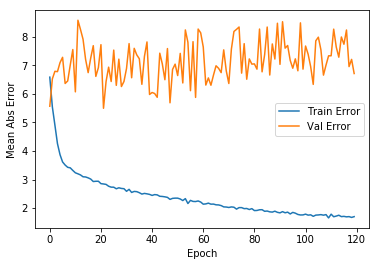

In [33]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
#     plt.ylim([0,5])
    plt.legend()
    plt.savefig(savedir + "History.png", dpi = 600, bbox_inches='tight')
    plt.show()


plot_history(history)

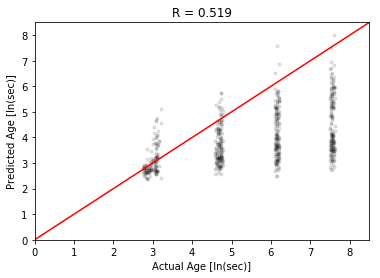

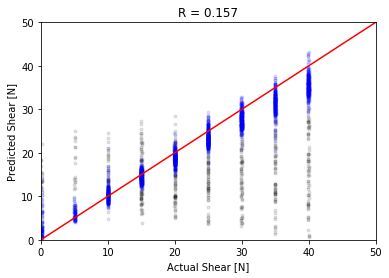

In [37]:
# Score and visualize predictions
from scipy.stats import pearsonr

train_times = train_labels[:,0]
train_pred_times = train_predic[:,0]

train_shear = train_labels[:,1]
train_pred_shear = train_predic[:,1]

test_times = test_labels[:,0]
test_pred_times = test_predic[:,0]

test_shear = test_labels[:,1]
test_pred_shear = test_predic[:,1]

plt.figure()
plt.scatter(test_times,test_pred_times, marker = ".", color = 'k', alpha = .1)
# plt.scatter(train_times, train_pred_times, marker = '.', color = 'b', alpha = .1)
plt.plot([0, 10], [0, 10], '-r')
plt.title('R = '+str(np.round(pearsonr(test_times, test_pred_times)[0], 3)))
plt.xlim(0,8.5)
plt.ylim(0,8.5)
plt.xlabel('Actual Age [ln(sec)]')
plt.ylabel('Predicted Age [ln(sec)]')
plt.savefig(savedir + "Age.png", dpi = 600, bbox_inches='tight')
plt.show()

plt.figure()
plt.scatter(test_shear,test_pred_shear, marker = ".", color = 'k', alpha = .1)
plt.scatter(train_shear, train_pred_shear, marker = '.', color = 'b', alpha = .1)
plt.title('R = '+str(np.round(pearsonr(test_shear, test_pred_shear)[0], 3)))
plt.plot([0, 100], [0, 100], '-r')
plt.xlim(0,50)
plt.ylim(0,50)
plt.xlabel('Actual Shear [N]')
plt.ylabel('Predicted Shear [N]')
plt.savefig(savedir + "Shear.png", dpi = 600, bbox_inches='tight')
plt.show()